In [7]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === 1. Load CSV and Filter to Binary Labels ===
label = pd.read_csv('./labeled_images.csv')  # Path to uploaded file

def binary_label(finding):
    if 'Pneumonia' in finding:
        return 'PNEUMONIA'
    elif finding.strip() == 'No Finding':
        return 'NORMAL'
    else:
        return None  # Exclude all other labels

label['binary_label'] = label['label'].apply(binary_label)
label_binary = label.dropna(subset=['binary_label']).copy()

# Optional: Check label distribution
print(label_binary['binary_label'].value_counts())

# === 2. Train/Validation Split ===
train_df, val_df = train_test_split(label_binary, test_size=0.2, random_state=42, stratify=label_binary['binary_label'])

binary_label
NORMAL       60361
PNEUMONIA     1431
Name: count, dtype: int64


In [9]:
# Separate classes
normal_df = label_binary[label_binary['binary_label'] == 'NORMAL']
pneumonia_df = label_binary[label_binary['binary_label'] == 'PNEUMONIA']

# Downsample NORMAL to 1450 samples
normal_sampled = normal_df.sample(n=1450, random_state=42)

# Combine balanced dataset
balanced_df = pd.concat([normal_sampled, pneumonia_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm new balance
print(balanced_df['binary_label'].value_counts())

# === Train/Validation Split ===
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['binary_label'], random_state=42)

binary_label
NORMAL       1450
PNEUMONIA    1431
Name: count, dtype: int64


In [12]:
balanced_df = balanced_df.drop("label",axis = 1)

In [13]:
balanced_df

,image_path,image_name,binary_label
0,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00011062_001.png,NORMAL
1,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00000468_029.png,PNEUMONIA
2,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00017710_009.png,PNEUMONIA
3,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00003028_050.png,PNEUMONIA
4,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00011721_000.png,NORMAL
...,...,...,...
2876,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00005927_006.png,PNEUMONIA
2877,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00013623_004.png,NORMAL
2878,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00022821_000.png,NORMAL
2879,/home/jovyan/.cache/kagglehub/datasets/nih-che...,00025652_001.png,NORMAL


In [14]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === 1. Drop 'image_name' and encode labels ===
balanced_df = balanced_df.drop('image_name', axis=1)
label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
balanced_df['label_encoded'] = balanced_df['binary_label'].map(label_map)

# === 2. Train/Validation Split ===
train_df, val_df = train_test_split(
    balanced_df[['image_path', 'label_encoded']],
    test_size=0.2,
    stratify=balanced_df['label_encoded'],
    random_state=42
)

# === 3. Load & Preprocess Images ===
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # Change to decode_jpeg if images are JPEG
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label_encoded'].values)
).map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label_encoded'].values)
).map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

# === 4. Build the Model ===
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 5. Train the Model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# === 6. Save the Model ===
os.makedirs('./saved_models', exist_ok=True)
model.save('./saved_models/nih_binary_model.keras')
print("✅ Binary model saved at ./saved_models/nih_binary_model.keras")

# === 7. Print Class Mapping ===
print("Label classes: {'NORMAL': 0, 'PNEUMONIA': 1}")

W0000 00:00:1753219378.035098     449 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5538 - loss: 0.7927 - val_accuracy: 0.6828 - val_loss: 0.6308
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.5928 - loss: 0.6796 - val_accuracy: 0.6863 - val_loss: 0.6177
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 599ms/step - accuracy: 0.6494 - loss: 0.6443 - val_accuracy: 0.6863 - val_loss: 0.6119
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 605ms/step - accuracy: 0.6407 - loss: 0.6291 - val_accuracy: 0.6967 - val_loss: 0.6065
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 611ms/step - accuracy: 0.6513 - loss: 0.6210 - val_accuracy: 0.7071 - val_loss: 0.5991
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 607ms/step - accuracy: 0.6793 - loss: 0.6097 - val_accuracy: 0.7071 - val_loss: 0.5961
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 595ms/step - accuracy: 0.6627 - loss: 0.6188 - val_accuracy: 0.7175 - val_loss: 0.5937
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step - accuracy: 0.6624 - loss: 0.6047 - val_accurac

In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === 1. Preprocess Data ===
# Assume balanced_df exists with ['image_path', 'binary_label'] columns
# Encode labels
label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
balanced_df['label_encoded'] = balanced_df['binary_label'].map(label_map)

# Train-test split
train_df, val_df = train_test_split(
    balanced_df[['image_path', 'label_encoded']],
    test_size=0.2,
    stratify=balanced_df['label_encoded'],
    random_state=42
)

# === 2. Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
])

# === 3. Load & Preprocess Images ===
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    image = data_augmentation(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label_encoded'].values)
).map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label_encoded'].values)
).map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

# === 4. Compute Class Weights ===
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_encoded']),
    y=train_df['label_encoded']
)
class_weights = dict(enumerate(class_weights))

# === 5. Define Model ===
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 6. Callbacks ===
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]

# === 7. Train Model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

# === 8. Save Model ===
os.makedirs('./saved_models', exist_ok=True)
model.save('./saved_models/nih_binary_model_finetuned.keras')
print("✅ Fine-tuned model saved at ./saved_models/nih_binary_model_finetuned.keras")

# === 9. Confirm Classes ===
print("Label classes: {'NORMAL': 0, 'PNEUMONIA': 1}")

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5410 - loss: 1.0321 - val_accuracy: 0.5719 - val_loss: 0.9077 - learning_rate: 1.0000e-05
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6069 - loss: 0.9348 - val_accuracy: 0.6568 - val_loss: 0.8450 - learning_rate: 1.0000e-05
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6253 - loss: 0.9104 - val_accuracy: 0.7002 - val_loss: 0.8147 - learning_rate: 1.0000e-05
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6669 - loss: 0.8660 - val_accuracy: 0.7054 - val_loss: 0.7888 - learning_rate: 1.0000e-05
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6722 - loss: 0.8498 - val_accuracy: 0.7192 - val_loss: 0.7799 - learning_rate: 1.0000e-05
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6790 - loss: 0.8579 - val_accuracy: 0.7348 - val_loss: 0.7585 - learning_rate: 1.0000e-05
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7028 - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
📋 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.78      0.74      0.76       290
   PNEUMONIA       0.75      0.79      0.77       287

    accuracy                           0.76       577
   macro avg       0.7

2025-07-22 23:37:00.298774: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


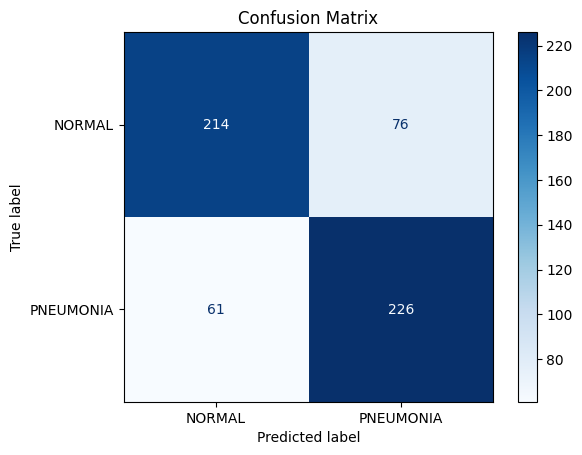

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === 1. Get true labels and predicted labels ===
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy().astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# === 2. Print Classification Report ===
target_names = ['NORMAL', 'PNEUMONIA']
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# === 3. Plot Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


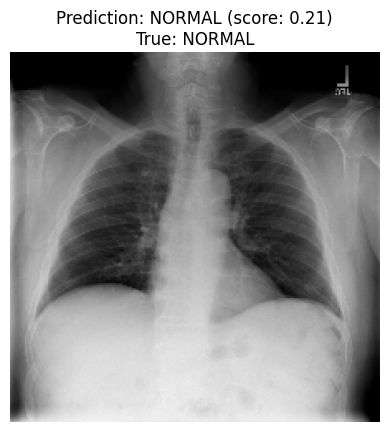

In [18]:
import random
import matplotlib.pyplot as plt

# === 1. Pick a random image from the validation set ===
sample = val_df.sample(1).iloc[0]
img_path = sample['image_path']
true_label = sample['label_encoded']

# === 2. Preprocess and predict ===
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

img_tensor = preprocess_image(img_path)
img_batch = tf.expand_dims(img_tensor, axis=0)

# Predict
prediction = model.predict(img_batch)[0][0]
pred_label = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
true_label_str = 'PNEUMONIA' if true_label == 1 else 'NORMAL'

# === 3. Display ===
plt.imshow(img_tensor)
plt.title(f"Prediction: {pred_label} (score: {prediction:.2f})\nTrue: {true_label_str}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


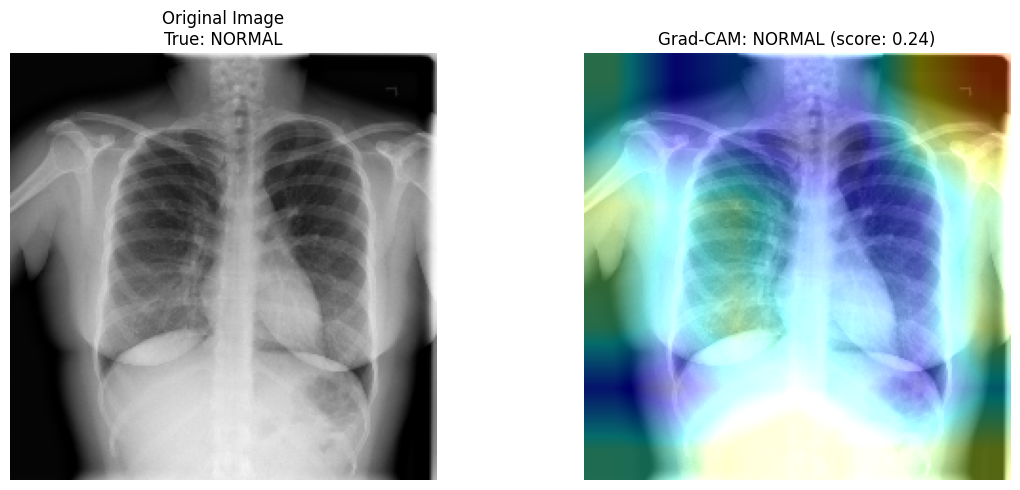

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === 1. Grad-CAM function for DenseNet121 inside Sequential ===
def make_gradcam_heatmap(img_array, model, conv_layer_name='conv5_block16_2_conv'):
    base_model = model.get_layer('densenet121')  # Get DenseNet121 inside Sequential

    # Build model from input to desired conv layer + output
    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[
            base_model.get_layer(conv_layer_name).output,
            base_model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

# === 2. Superimpose Heatmap ===
def superimpose_heatmap(heatmap, img_tensor, alpha=0.4):
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_np = np.uint8(img_tensor * 255)
    superimposed_img = heatmap_color * alpha + img_np
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)

# === 3. Run Grad-CAM on a Random Image ===
sample = val_df.sample(1).iloc[0]
img_path = sample['image_path']
true_label = sample['label_encoded']
true_label_str = 'PNEUMONIA' if true_label == 1 else 'NORMAL'

# Load and preprocess image
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

img_tensor = preprocess_image(img_path)
img_batch = tf.expand_dims(img_tensor, axis=0)

# Predict
prediction = model.predict(img_batch)[0][0]
pred_label = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'

# Grad-CAM
heatmap = make_gradcam_heatmap(img_batch, model, conv_layer_name='conv5_block16_2_conv')
superimposed = superimpose_heatmap(heatmap, img_tensor)

# === 4. Show Results ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title(f"Original Image\nTrue: {true_label_str}")
plt.imshow(img_tensor)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM: {pred_label} (score: {prediction:.2f})")
plt.imshow(superimposed)
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🔍 Total misclassified samples: 146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2025-07-22 23:41:46.167870: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


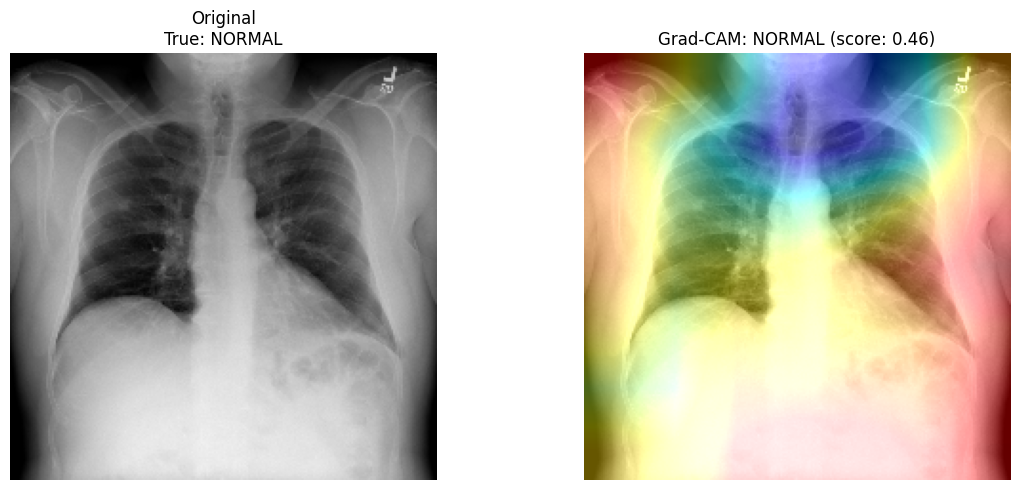

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


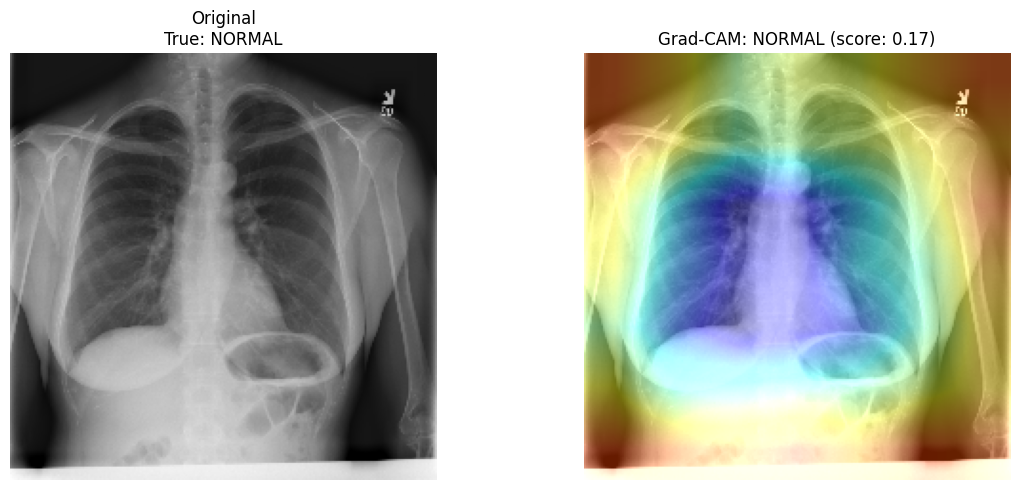

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


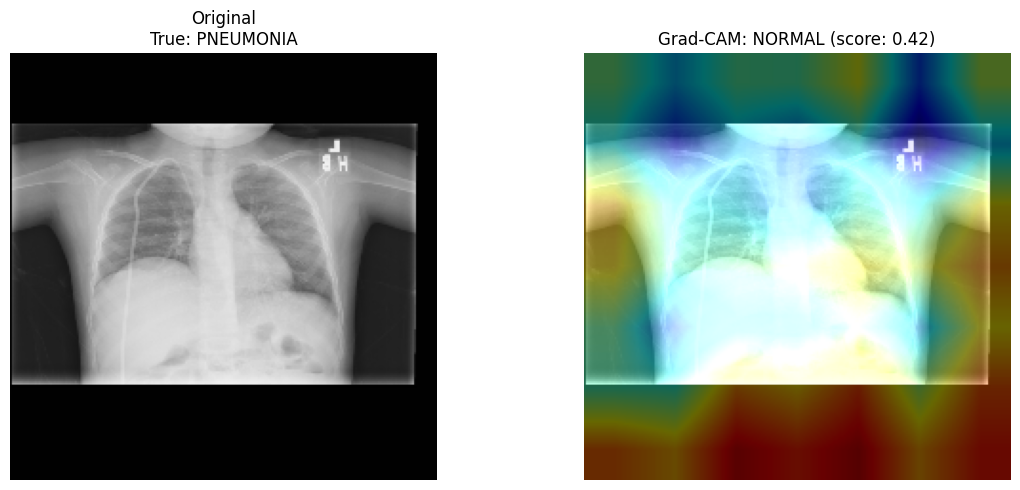

In [24]:
# === Step 1: Collect Predictions on Validation Set ===
y_true = []
y_pred = []
image_paths = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(int).flatten()
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds_binary)
    image_paths.extend(images.numpy())  # Save for later

# === Step 2: Identify Misclassified Indices ===
misclassified_idxs = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

print(f"🔍 Total misclassified samples: {len(misclassified_idxs)}")

# === Step 3: Grad-CAM on 3 Random Misclassified Images ===
import random

sample_misclassified = random.sample(misclassified_idxs, min(3, len(misclassified_idxs)))

for idx in sample_misclassified:
    img_path = val_df.iloc[idx]['image_path']
    true_label = val_df.iloc[idx]['label_encoded']
    true_str = 'PNEUMONIA' if true_label == 1 else 'NORMAL'

    img_tensor = preprocess_image(img_path)
    img_batch = tf.expand_dims(img_tensor, axis=0)

    prediction = model.predict(img_batch)[0][0]
    pred_label = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'

    heatmap = make_gradcam_heatmap(img_batch, model, conv_layer_name='conv5_block16_2_conv')
    superimposed = superimpose_heatmap(heatmap, img_tensor)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_tensor)
    plt.title(f"Original\nTrue: {true_str}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM: {pred_label} (score: {prediction:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()